In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from time import time
from operator import itemgetter

import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

from sklearn import cross_validation
from sklearn import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import grid_search

from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve


In [2]:
titanic = sns.load_dataset("titanic")

headers = [c for c in titanic.columns]
headers.insert(0,"ID")
print tabulate(titanic[0:5], headers, tablefmt="pipe")

|   ID |   survived |   pclass | sex    |   age |   sibsp |   parch |    fare | embarked   | class   | who   |   adult_male | deck   | embark_town   | alive   |   alone |
|-----:|-----------:|---------:|:-------|------:|--------:|--------:|--------:|:-----------|:--------|:------|-------------:|:-------|:--------------|:--------|--------:|
|    0 |          0 |        3 | male   |    22 |       1 |       0 |  7.25   | S          | Third   | man   |            1 | nan    | Southampton   | no      |       0 |
|    1 |          1 |        1 | female |    38 |       1 |       0 | 71.2833 | C          | First   | woman |            0 | C      | Cherbourg     | yes     |       0 |
|    2 |          1 |        3 | female |    26 |       0 |       0 |  7.925  | S          | Third   | woman |            0 | nan    | Southampton   | yes     |       1 |
|    3 |          1 |        1 | female |    35 |       1 |       0 | 53.1    | S          | First   | woman |            0 | C      | Southampto

In [3]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [50]:
# カテゴリ変数をダミー変数化
def convert_dummies(df, key):
    dum = pd.get_dummies(df[key])
    ks = dum.keys()
    print "Removing {} from {}...".format(ks[0], key)
    dum.columns = [key + "_" + str(k) for k in ks]  
    df = pd.concat((df, dum.ix[:,1:]), axis=1)
    df = df.drop(key, axis=1)
    return df

In [52]:
titanic = convert_dummies(titanic, "who")
titanic = convert_dummies(titanic, "class")
titanic = convert_dummies(titanic, "sex")
titanic = convert_dummies(titanic, "alone")
titanic = convert_dummies(titanic, "embark_town")
titanic = convert_dummies(titanic, "deck")
titanic = convert_dummies(titanic, "embarked")

titanic['age'] = titanic.age.fillna(titanic.age.median())
titanic['adult_male'] = titanic.adult_male.map( {True: 1, False: 0} ).astype(int)
titanic['alone'] = titanic.adult_male.map( {True: 1, False: 0} ).astype(int)

Removing child from who...
Removing First from class...
Removing female from sex...
Removing False from alone...
Removing Cherbourg from embark_town...
Removing A from deck...
Removing C from embarked...


In [53]:
# keyの一覧
for k in titanic.keys():
    print k,

survived pclass age sibsp parch fare adult_male alive who_man who_woman class_Second class_Third sex_male alone_True embark_town_Queenstown embark_town_Southampton deck_B deck_C deck_D deck_E deck_F deck_G embarked_Q embarked_S alone


In [54]:
# 使用しない変数をドロップ
titanic = titanic.drop("alive", axis=1)
titanic = titanic.drop("pclass", axis=1)

In [55]:
# 再確認
titanic.head()

,survived,age,sibsp,parch,fare,adult_male,who_man,who_woman,class_Second,class_Third,...,embark_town_Southampton,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,embarked_Q,embarked_S,alone
0,0,22,1,0,7.2500,1,1,0,0,1,...,1,0,0,0,0,0,0,0,1,1
1,1,38,1,0,71.2833,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,26,0,0,7.9250,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,0
3,1,35,1,0,53.1000,0,0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
4,0,35,0,0,8.0500,1,1,0,0,1,...,1,0,0,0,0,0,0,0,1,1


In [56]:
# ファイルに書き出し
titanic.to_csv("./titanic_converted2.csv", index=False)

## 訓練データとテストデータの作成

### ホールドアウト法

In [77]:
# 訓練データ(80%), テストデータ(20%)に分割する
target = titanic.ix[:, 0]
data = titanic.ix[:, :]#[1,2,3,4,5,6,7,8,9,10,11,12,13]]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.2, random_state=2)

print [d.shape for d in [X_train, X_test, y_train, y_test]]

[(712, 23), (179, 23), (712,), (179,)]


In [78]:
# SVM(線形カーネル)で分類し、誤り率を算出
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print u"再代入誤り率：", 1 - clf.score(X_train, y_train)   
print u"ホールドアウト誤り率：", 1 - clf.score(X_test, y_test)   


再代入誤り率： 0.0
ホールドアウト誤り率： 0.0


In [79]:
# SVM(rbfカーネル)で分類し、誤り率を算出
clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train)
print u"再代入誤り率：", 1 - clf.score(X_train, y_train)   
print u"ホールドアウト誤り率：", 1 - clf.score(X_test, y_test)   



再代入誤り率： 0.0365168539326
ホールドアウト誤り率： 0.178770949721


### KFold法

In [60]:
# KFold
# n_foldsで指定した数値でデータを分割。n_folds=5とした場合、5分割
# してそのうちの１つをテストデータとし、5通りパターンを生成する。
kf = KFold(30, n_folds=5,shuffle=False)
for tr, ts in kf:
    print("%s %s" % (tr, ts))

[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [0 1 2 3 4 5]
[ 0  1  2  3  4  5 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [ 6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 18 19 20 21 22 23 24 25 26 27 28 29] [12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 24 25 26 27 28 29] [18 19 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] [24 25 26 27 28 29]


In [61]:
# StratifiedKFold
# 各クラスごとの抽出率を元データの比率に合わせたKFoldの改良版

label = np.r_[np.repeat(0,20), np.repeat(1,10)]
skf = StratifiedKFold(label, n_folds=5, shuffle=False)
for tr, ts in skf:
    print("%s %s" % (tr, ts))

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 23 24 25 26 27 28 29] [ 0  1  2  3 20 21]
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27 28 29] [ 4  5  6  7 22 23]
[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19 20 21 22 23 26 27 28 29] [ 8  9 10 11 24 25]
[ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19 20 21 22 23 24 25 28 29] [12 13 14 15 26 27]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 26 27] [16 17 18 19 28 29]


### 実行

In [62]:
# SVM(線形カーネル)で分類し、誤り率を算出
# 5分割のStratifiedKFoldでそれぞれスコアを算出

clf = svm.SVC(kernel='rbf', C=1)
scores = cross_validation.cross_val_score(clf, data, target, cv=5,)
print "scores: ", scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

scores:  [ 0.79329609  0.83240223  0.85955056  0.83146067  0.87570621]
Accuracy: 0.84 (+/- 0.06)


## ハイパーパラメーターを探す

### Exhausted Grid Search

In [63]:
param_grid = [
  {'kernel': ['rbf','linear'], 'C': np.linspace(0.1,2.0,20),}
 ]
svc = svm.SVC(random_state=None)
clf = grid_search.GridSearchCV(svc, param_grid)
res = clf.fit(X_train, y_train)
print "", clf.score(X_test, y_test)
print "", res.best_params_
print "", res.best_estimator_

 1.0
 {'kernel': 'linear', 'C': 0.10000000000000001}
 SVC(C=0.10000000000000001, cache_size=200, class_weight=None, coef0=0.0,
  degree=3, gamma=0.0, kernel='linear', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)


In [64]:
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
               'C': [0.1, 1, 20]},
              {'kernel': ['linear'], 'C': [0.1, 1, 20]}]
svc = svm.SVC(random_state=None)
clf = grid_search.GridSearchCV(svc, param_grid)
res = clf.fit(X_train, y_train)
print "", clf.score(X_test, y_test)
print "", res.best_params_
print "", res.best_estimator_

 1.0
 {'kernel': 'linear', 'C': 0.1}
 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


### RandomizedSearchCV

In [65]:
param_dist = {'n_estimators': range(4,20,2), 'min_samples_split': range(1,30,2), 'criterion':['gini','entropy']}

In [66]:
n_iter_search = 20
rfc = RandomForestClassifier(max_depth=None, min_samples_split=1, random_state=None)
random_search = grid_search.RandomizedSearchCV(rfc, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)
start = time()
random_search.fit(X_train, y_train)
end   = time()
print"パラメーター数: {0}, 経過時間: {1:0.3f}秒".format(n_iter_search, end - start)

パラメーター数: 20, 経過時間: 0.767秒


In [67]:
# トップ3パラメータ
top_scores = sorted(random_search.grid_scores_, key=itemgetter(1), reverse=True)[:3]
for i, score in enumerate(top_scores):
    print("Model with rank: {0}".format(i + 1))
    print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
          score.mean_validation_score,
          np.std(score.cv_validation_scores)))
    print("Parameters: {0}".format(score.parameters))
    print("")

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'min_samples_split': 13, 'n_estimators': 18, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 1.000 (std: 0.000)
Parameters: {'min_samples_split': 9, 'n_estimators': 14, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 1.000 (std: 0.000)
Parameters: {'min_samples_split': 25, 'n_estimators': 16, 'criterion': 'gini'}



## 評価指標

In [81]:
# SVM(線形カーネル)で分類し、評価指標を算出
clf = svm.SVC(kernel='linear', C=1, probability=True).fit(X_train, y_train)
print u"Accuracy:", clf.score(X_test, y_test)   
y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred, target_names=["not Survived", "Survived"])

Accuracy: 1.0
              precision    recall  f1-score   support

not Survived       1.00      1.00      1.00       100
    Survived       1.00      1.00      1.00        79

 avg / total       1.00      1.00      1.00       179



### ROC曲線とAUC

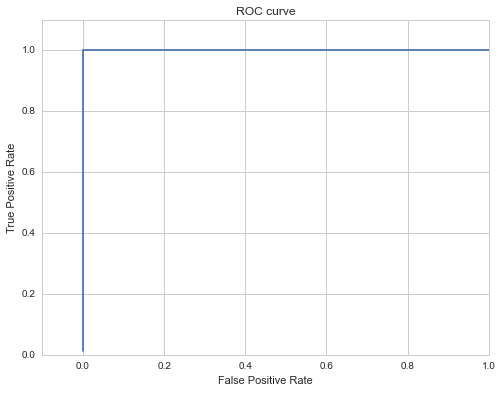

In [83]:
prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds= roc_curve(y_test, prob)

plt.figure(figsize=(8,6))
plt.xlim(-0.1, 1)
plt.ylim(0, 1.1)
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [70]:
precision, recall, thresholds = precision_recall_curve(y_test, prob)
area = auc(recall, precision)
print "Area Under Curve: {0:.3f}".format(area)

Area Under Curve: 1.000
